In [101]:
from IPython.display import display

import itertools
import re
import requests
import time

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import unidecode

In [2]:
salary_base_url = 'https://hoopshype.com/salaries/players/'
start_year = 2012
end_year = 2021
years = [i for i in range(start_year, end_year + 1)]
salary_caps = {2012: 58044000, 2013: 58044000, 2014: 58679000, 2015: 63065000, 2016: 70000000,
               2017: 94143000, 2018: 99093000, 2019: 101869000, 2020: 109140000, 2021: 109140000}

salary_dfs = []
for year in years:
    if year == 2021:
        salary_url = salary_base_url
    else:
        # get years in form 2020-2021 for url
        salary_url = f'{salary_base_url}{year-1}-{year}'
        
    r = requests.get(salary_url, timeout=10)
    
    if r.status_code != 200:
        print(f'{r.status_code} Error querying {salaries_base}{year}')
        break

    soup = BeautifulSoup(r.text, 'html.parser')
    salary_table = soup.find_all('table', class_='hh-salaries-ranking-table hh-salaries-table-sortable responsive')[0]
    
    name_html = salary_table.find_all('td', class_='name')
    # format names
    names = [re.sub(r"[\n\t]*", "", name.text) for name in name_html]
    names = [unidecode.unidecode(name) for name in names]
    names.pop(0)

    if year == 2021:
        salary_html = salary_table.find_all('td', class_='hh-salaries-sorted')
        salaries = [re.sub(r"[\n\t]*", "", salary.text) for salary in salary_html]
        salaries.pop(0)
    else:
        all_cells = salary_table.find_all('td')
        salaries = [re.sub(r"[\n\t]*", "", all_cells[i].text) for i in range(6, len(all_cells), 4)]
    salaries = [float(re.sub(r"[$,]*", "", salary)) for salary in salaries]
    salary_pcts = [salary / salary_caps[year] for salary in salaries]
    salary_dfs.append(pd.DataFrame({'Player': names, 'Year': year, 'Salary': salaries, 'Salary %': salary_pcts}))
    time.sleep(2.5)

salary_df = pd.concat(salary_dfs)

In [3]:
stats_base_url = 'https://www.basketball-reference.com/leagues/'

stat_cols = ['Player', 'Position', 'Age', 'Team', 'GP', 'GS', 'Minutes', 'FGM', 'FGA', 'FG%', 
             '3PM', '3PA', '3P%', '2PM', '2PA', '2P%', 'eFG%', 'FTM', 'FTA', 'FT%',
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']
stats_dfs = []
for year in years:
    stats_url = f'{stats_base_url}NBA_{year}_per_game.html'
    
    r = requests.get(stats_url, timeout=10)
    
    if r.status_code != 200:
        print(f'{r.status_code} Error querying {salaries_base}{year}')
        break
        
    soup = BeautifulSoup(r.text, 'html.parser')
    
    players_html = soup.find_all('tr', class_='full_table')
    player_list = []
    for player in players_html:
        player_stats = [stat.text for stat in player.find_all('td')]
        player_list.append(player_stats)
    
    year_stat_df = pd.DataFrame(player_list, columns=stat_cols)
    year_stat_df.insert(1, 'Year', year)
    year_stat_df['Player'] = year_stat_df['Player'].apply(lambda x: unidecode.unidecode(x))
    stats_dfs.append(year_stat_df)
    time.sleep(2.5)

stats_df = pd.concat(stats_dfs)

df = pd.merge(salary_df, stats_df, how='inner', on=['Player', 'Year'])
df['Age'] = df['Age'].astype(float)

for i in range(9, len(df.columns)):
    df[df.columns[i]] = pd.to_numeric(df[df.columns[i]]).astype(float)

game_df = df.copy()


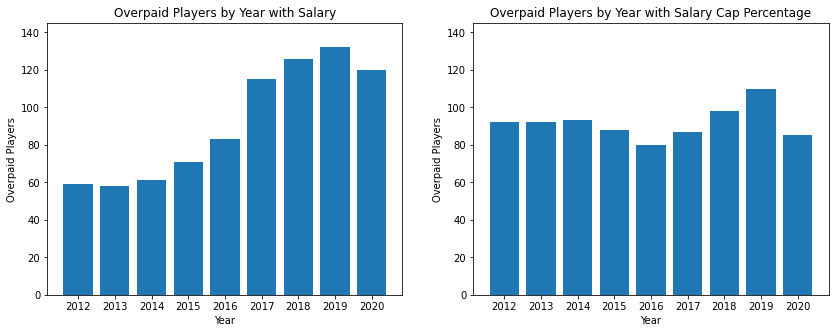

In [4]:
preds = ['Age', 'Minutes', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

mod = sm.OLS(train_y, train_x)
reg = mod.fit()

# Calculate overpaid players using salary and salary cap percentage
train_df = df.loc[df['Year'] != 2021][['Player', 'Year', 'Salary']]
train_df['Pred'] = reg.predict(train_x)
train_df['Diff'] = train_df['Salary'] - train_df['Pred']
train_df.sort_values(by=['Diff'], inplace=True)
train_df['quantile'] = pd.qcut(train_df['Diff'], q=5, labels=False)
salary_q5 = train_df.loc[train_df['quantile'] == 4].groupby('Year').count()
salary_q5.reset_index(inplace=True)
salary_q5 = salary_q5[['Year', 'Player']]
salary_q5.rename(columns={'Player': 'Overpaid Players'}, inplace=True)

train_y = df.loc[df['Year'] != 2021]['Salary %']
mod = sm.OLS(train_y, train_x)
reg = mod.fit()

train_df = df.loc[df['Year'] != 2021][['Player', 'Year', 'Salary %']]
train_df['Pred'] = reg.predict(train_x)
train_df['Diff'] = train_df['Salary %'] - train_df['Pred']
train_df.sort_values(by=['Diff'], inplace=True)
train_df['quantile'] = pd.qcut(train_df['Diff'], q=5, labels=False)
salary_pct_q5 = train_df.loc[train_df['quantile'] == 4].groupby('Year').count()
salary_pct_q5.reset_index(inplace=True)
salary_pct_q5 = salary_pct_q5[['Year', 'Player']]
salary_pct_q5.rename(columns={'Player': 'Overpaid Players'}, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(salary_q5['Year'], salary_q5['Overpaid Players'])
ax1.set_xticks(years[:-1])
ax1.set_ylim([0, 145])
ax1.set_xlabel('Year')
ax1.set_ylabel('Overpaid Players')
ax1.set_title('Overpaid Players by Year with Salary')
ax2.bar(salary_pct_q5['Year'], salary_pct_q5['Overpaid Players'])
ax2.set_xticks(years[:-1])
ax2.set_ylim([0, 145])
ax2.set_xlabel('Year')
ax2.set_ylabel('Overpaid Players')
ax2.set_title('Overpaid Players by Year with Salary Cap Percentage')
# fig.savefig('init_overvalued.png')


In [5]:
# basic per game stat regression
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.709
Model:                            OLS   Adj. R-squared (uncentered):              0.708
Method:                 Least Squares   F-statistic:                              527.3
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                        0.00
Time:                        11:18:04   Log-Likelihood:                          6106.8
No. Observations:                4124   AIC:                                 -1.218e+04
Df Residuals:                    4105   BIC:                                 -1.206e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0008   8.74e-05      9.305      0.000       0.001       0.001
Minutes        0.0002      0.000      0.643      0.520      -0.000       0.001
FGM            0.0201      0.028      0.714      0.475      -0.035       0.075
FGA            0.0322      0.019      1.715      0.086      -0.005       0.069
3PM           -0.0218      0.025     -0.874      0.382      -0.071       0.027
3PA           -0.0389      0.019     -2.071      0.038      -0.076      -0.002
2PM           -0.0318      0.020     -1.571      0.116      -0.071       0.008
2PA           -0.0302      0.019     -1.606      0.108      -0.067       0.007
FTM            0.0055      0.012      0.450      0.653      -0.018       0.029
FTA           -0.0033      0.003     -0.987      0.324      -0.010       0.003
ORB           -0.0259      0.018     -1.450      0.147      -0.061       0.009
DRB           -0.0130      0.018     -0.730      0.465      -0.048       0.022
TRB            0.0255      0.018      1.431      0.152      -0.009       0.060
AST            0.0079      0.001      7.354      0.000       0.006       0.010
STL           -0.0100      0.003     -2.952      0.003      -0.017      -0.003
BLK            0.0099      0.003      3.263      0.001       0.004       0.016
TO            -0.0025      0.003     -0.811      0.417      -0.009       0.004
PF            -0.0219      0.002    -11.146      0.000      -0.026      -0.018
PTS            0.0087      0.012      0.737      0.461      -0.014       0.032
==============================================================================
Omnibus:                      792.622   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1948.036
Skew:                           1.060   Prob(JB):                         0.00
Kurtosis:                       5.616   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [167]:
stat_cols = ['Player', 'Position', 'Age', 'Team', 'GP', 'GS', 'Minutes', 'FGM', 'FGA', 'FG%', 
             '3PM', '3PA', '3P%', '2PM', '2PA', '2P%', 'FTM', 'FTA', 'FT%',
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'Empty', 'ORtg', 'DRtg']

stats_base_url = 'https://www.basketball-reference.com/leagues/'

stats_dfs = []
for year in years:
    stats_url = f'{stats_base_url}NBA_{year}_per_poss.html'
    
    r = requests.get(stats_url, timeout=10)
    
    if r.status_code != 200:
        print(f'{r.status_code} Error querying {salaries_base}{year}')
        break
        
    soup = BeautifulSoup(r.text, 'html.parser')
    
    players_html = soup.find_all('tr', class_='full_table')
    player_list = []
    for player in players_html:
        player_stats = [stat.text for stat in player.find_all('td')]
        player_list.append(player_stats)
    
    year_stat_df = pd.DataFrame(player_list, columns=stat_cols)
    year_stat_df.drop(columns=['Empty'], inplace=True)
    year_stat_df.insert(1, 'Year', year)
    year_stat_df['Player'] = year_stat_df['Player'].apply(lambda x: unidecode.unidecode(x))
    stats_dfs.append(year_stat_df)
    time.sleep(2.5)

stats_df = pd.concat(stats_dfs)

df = pd.merge(salary_df, stats_df, how='inner', on=['Player', 'Year'])
df['Age'] = df['Age'].astype(float)

for i in range(9, len(df.columns)):
    df[df.columns[i]] = pd.to_numeric(df[df.columns[i]]).astype(float)
    

df = df[df['ORtg'].notna()]
poss_df = df.copy()

preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'ORtg', 'DRtg']

train_x = poss_df.loc[poss_df['Year'] != 2021][preds]
train_y = poss_df.loc[poss_df['Year'] != 2021]['Salary %']
test_x = poss_df.loc[poss_df['Year'] == 2021][preds]
test_y = poss_df.loc[poss_df['Year'] == 2021]['Salary %']

mod = sm.OLS(train_y, train_x)
reg = mod.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.658
Model:                            OLS   Adj. R-squared (uncentered):              0.656
Method:                 Least Squares   F-statistic:                              393.9
Date:                Mon, 03 May 2021   Prob (F-statistic):                        0.00
Time:                        14:37:55   Log-Likelihood:                          5752.4
No. Observations:                4114   AIC:                                 -1.146e+04
Df Residuals:                    4094   BIC:                                 -1.134e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0059      0.000     26.807      0.000       0.005       0.006
FGM           -0.0249      0.030     -0.838      0.402      -0.083       0.033
FGA            0.0405      0.020      2.061      0.039       0.002       0.079
3PM           -0.0083      0.027     -0.311      0.756      -0.061       0.044
3PA           -0.0426      0.020     -2.170      0.030      -0.081      -0.004
2PM            0.0011      0.021      0.053      0.958      -0.041       0.043
2PA           -0.0402      0.020     -2.048      0.041      -0.079      -0.002
FTM           -0.0064      0.013     -0.507      0.612      -0.031       0.018
FTA            0.0004      0.001      0.404      0.686      -0.002       0.002
ORB            0.0056      0.019      0.296      0.767      -0.031       0.042
DRB            0.0103      0.019      0.545      0.586      -0.027       0.047
TRB           -0.0066      0.019     -0.351      0.725      -0.043       0.030
AST            0.0036      0.000      7.786      0.000       0.003       0.004
STL           -0.0019      0.001     -1.718      0.086      -0.004       0.000
BLK            0.0021      0.001      1.947      0.052   -1.47e-05       0.004
TO            -0.0011      0.001     -1.109      0.267      -0.003       0.001
PF            -0.0068      0.001    -13.360      0.000      -0.008      -0.006
PTS            0.0151      0.013      1.200      0.230      -0.010       0.040
ORtg          -0.0003      0.000     -2.385      0.017      -0.001   -5.13e-05
DRtg          -0.0013      0.000    -10.584      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      457.948   Durbin-Watson:                   0.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.282
Skew:                           0.769   Prob(JB):                    7.36e-169
Kurtosis:                       4.467   Cond. No.                     6.10e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# regression with only one REB
preds = ['Age', 'Minutes', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

mod = sm.OLS(train_y, train_x)
reg = mod.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.708
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              622.1
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                        0.00
Time:                        12:03:11   Log-Likelihood:                          6096.1
No. Observations:                4124   AIC:                                 -1.216e+04
Df Residuals:                    4108   BIC:                                 -1.206e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0008   8.23e-05     10.050      0.000       0.001       0.001
FGM            0.0189      0.028      0.670      0.503      -0.036       0.074
FGA            0.0307      0.019      1.629      0.103      -0.006       0.068
3PM           -0.0226      0.025     -0.902      0.367      -0.072       0.026
3PA           -0.0357      0.019     -1.896      0.058      -0.073       0.001
2PM           -0.0321      0.020     -1.584      0.113      -0.072       0.008
2PA           -0.0284      0.019     -1.506      0.132      -0.065       0.009
FTM            0.0062      0.012      0.505      0.614      -0.018       0.030
FTA           -0.0043      0.003     -1.281      0.200      -0.011       0.002
TRB            0.0091      0.001     12.694      0.000       0.008       0.011
AST            0.0087      0.001      8.307      0.000       0.007       0.011
STL           -0.0093      0.003     -2.885      0.004      -0.016      -0.003
BLK            0.0101      0.003      3.300      0.001       0.004       0.016
TO            -0.0022      0.003     -0.705      0.481      -0.008       0.004
PF            -0.0227      0.002    -12.597      0.000      -0.026      -0.019
PTS            0.0092      0.012      0.780      0.436      -0.014       0.032
==============================================================================
Omnibus:                      791.692   Durbin-Watson:                   0.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1944.748
Skew:                           1.059   Prob(JB):                         0.00
Kurtosis:                       5.614   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# correlation matrix
game_df[['Minutes', 'TRB', 'AST', 'BLK', 'STL', 'PF', 'PTS']].corr()

,Minutes,TRB,AST,BLK,STL,PF,PTS
Minutes,1.000000,0.668110,0.678469,0.389820,0.760180,0.723578,0.882886
TRB,0.668110,1.000000,0.281699,0.701756,0.430948,0.695597,0.622656
AST,0.678469,0.281699,1.000000,0.036286,0.696563,0.382122,0.688107
BLK,0.389820,0.701756,0.036286,1.000000,0.224691,0.543467,0.345380
STL,0.760180,0.430948,0.696563,0.224691,1.000000,0.544777,0.674458
PF,0.723578,0.695597,0.382122,0.543467,0.544777,1.000000,0.591221
PTS,0.882886,0.622656,0.688107,0.345380,0.674458,0.591221,1.000000


In [78]:
# first regression model with TRB and PTS
preds = ['Age', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

reg = sm.OLS(train_y, train_x).fit()
display(reg.summary())

pred_y = reg.predict(test_x)

metrics_cols = ['Model', 'R^2', 'MAE', 'RMSE']
initial_metrics = ['Initial', r2_score(test_y, pred_y), mean_absolute_error(test_y, pred_y), 
                   np.sqrt(mean_squared_error(test_y, pred_y))]
metrics_df = pd.DataFrame([initial_metrics], 
                         columns=metrics_cols)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.706
Model:                            OLS   Adj. R-squared (uncentered):              0.705
Method:                 Least Squares   F-statistic:                              1410.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:48:25   Log-Likelihood:                          6080.4
No. Observations:                4124   AIC:                                 -1.215e+04
Df Residuals:                    4117   BIC:                                 -1.210e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0008    7.9e-05      9.653      0.000       0.001       0.001
TRB            0.0092      0.001     14.414      0.000       0.008       0.010
AST            0.0086      0.001     10.937      0.000       0.007       0.010
STL           -0.0110      0.003     -3.458      0.001      -0.017      -0.005
BLK            0.0106      0.003      3.598      0.000       0.005       0.016
PF            -0.0240      0.002    -13.896      0.000      -0.027      -0.021
PTS            0.0055      0.000     20.961      0.000       0.005       0.006
==============================================================================
Omnibus:                      767.383   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1845.460
Skew:                           1.036   Prob(JB):                         0.00
Kurtosis:                       5.539   Cond. No.                         106.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# first regression model with scaled params
preds = ['Age', 'TRB', 'AST', 'BLK', 'STL', 'PF', 'PTS']

scaler = StandardScaler().fit(game_df[preds])

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

train_x = pd.DataFrame(scaler.transform(train_x), columns=preds)
reg = sm.OLS(train_y, train_x).fit()
display(reg.summary())

test_x = pd.DataFrame(scaler.transform(test_x), columns=preds)
pred_y = reg.predict(test_x)

metrics_df = metrics_df.append(pd.DataFrame([['Scaled', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                            columns=metrics_cols))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.306
Model:                            OLS   Adj. R-squared (uncentered):              0.305
Method:                 Least Squares   F-statistic:                              259.5
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                   4.90e-321
Time:                        16:48:53   Log-Likelihood:                          4312.6
No. Observations:                4124   AIC:                                     -8611.
Df Residuals:                    4117   BIC:                                     -8567.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0235      0.001     17.653      0.000       0.021       0.026
TRB            0.0205      0.002      8.395      0.000       0.016       0.025
AST            0.0109      0.002      5.060      0.000       0.007       0.015
BLK            0.0042      0.002      2.173      0.030       0.000       0.008
STL           -0.0004      0.002     -0.214      0.831      -0.005       0.004
PF            -0.0096      0.002     -4.695      0.000      -0.014      -0.006
PTS            0.0329      0.002     13.604      0.000       0.028       0.038
==============================================================================
Omnibus:                      507.953   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.272
Skew:                           0.741   Prob(JB):                    2.00e-244
Kurtosis:                       5.083   Cond. No.                         4.42
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
# first regression model with normalized params
preds = ['Age', 'TRB', 'AST', 'BLK', 'STL', 'PF', 'PTS']

scaler = Normalizer().fit(game_df[preds])

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

train_x = pd.DataFrame(scaler.transform(train_x), columns=preds)
reg = sm.OLS(train_y, train_x).fit()
display(reg.summary())

test_x = pd.DataFrame(scaler.transform(test_x), columns=preds)
pred_y = reg.predict(test_x)

metrics_df = metrics_df.append(pd.DataFrame([['Normalized', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                            columns=metrics_cols))
metrics_df

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.639
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              1039.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                        0.00
Time:                        16:48:55   Log-Likelihood:                          5657.8
No. Observations:                4124   AIC:                                 -1.130e+04
Df Residuals:                    4117   BIC:                                 -1.126e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0177      0.002      7.293      0.000       0.013       0.022
TRB            0.2851      0.021     13.351      0.000       0.243       0.327
AST            0.2892      0.026     10.973      0.000       0.238       0.341
BLK            0.3212      0.095      3.388      0.001       0.135       0.507
STL           -0.4987      0.101     -4.931      0.000      -0.697      -0.300
PF            -0.8405      0.053    -15.715      0.000      -0.945      -0.736
PTS            0.1984      0.009     22.023      0.000       0.181       0.216
==============================================================================
Omnibus:                      655.075   Durbin-Watson:                   0.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1271.833
Skew:                           0.976   Prob(JB):                    6.68e-277
Kurtosis:                       4.895   Cond. No.                         105.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Model,R^2,MAE,RMSE
0,Initial,0.562862,0.042490,0.056019
0,Scaled,0.052969,0.067930,0.082453
0,Normalized,0.426121,0.048216,0.064185


In [139]:
# stepwise regression feature selection in Python 
def stepwise_features(X, y, initial_list=[], threshold_in=0.04, threshold_out=0.05):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, pd.DataFrame(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True

        # backward step
        model = sm.OLS(y, pd.DataFrame(X[included])).fit()
        # use all coefs
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)

        if not changed:
            break
    return included

preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']

preds = stepwise_features(train_x, train_y)
print(preds)

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

reg = sm.OLS(train_y, train_x).fit()
display(reg.summary())

pred_y = reg.predict(test_x)

metrics_df2 = pd.DataFrame([initial_metrics], columns=metrics_cols)
metrics_df2 = metrics_df2.append(pd.DataFrame([['Stepwise', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))

metrics_df2

['FTM', 'DRB', 'AST', 'FGM', 'PF', 'Age', 'BLK', 'STL']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.708
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              1248.
Date:                Wed, 28 Apr 2021   Prob (F-statistic):                        0.00
Time:                        17:56:05   Log-Likelihood:                          6097.2
No. Observations:                4124   AIC:                                 -1.218e+04
Df Residuals:                    4116   BIC:                                 -1.213e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FTM            0.0097      0.001      7.844      0.000       0.007       0.012
DRB            0.0121      0.001     13.603      0.000       0.010       0.014
AST            0.0074      0.001      9.435      0.000       0.006       0.009
FGM            0.0096      0.001     10.155      0.000       0.008       0.011
PF            -0.0220      0.002    -12.944      0.000      -0.025      -0.019
Age            0.0008   7.93e-05     10.182      0.000       0.001       0.001
BLK            0.0100      0.003      3.494      0.000       0.004       0.016
STL           -0.0101      0.003     -3.191      0.001      -0.016      -0.004
==============================================================================
Omnibus:                      780.098   Durbin-Watson:                   0.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1907.177
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                       5.593   Cond. No.                         101.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Model,R^2,MAE,RMSE
0,Initial,0.562862,0.042490,0.056019
0,Stepwise,0.566595,0.041838,0.055779


In [140]:
preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

reg = Lasso(alpha=0.001).fit(train_x, train_y)
lasso_df = pd.DataFrame({'Feature': preds, 'normal':reg.coef_})

pred_y = reg.predict(test_x)

metrics_df2 = metrics_df2.append(pd.DataFrame([['Lasso', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))


In [141]:
scaler = StandardScaler().fit(game_df[preds])

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

test_x = pd.DataFrame(scaler.transform(test_x), columns=preds)
train_x = pd.DataFrame(scaler.transform(train_x), columns=preds)
reg = Lasso(alpha=0.002, max_iter=10000).fit(train_x, train_y)
lasso_df['standardized'] = reg.coef_

pred_y = reg.predict(test_x)

metrics_df2 = metrics_df2.append(pd.DataFrame([['Lasso Scaled', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))


In [142]:
scaler = Normalizer().fit(game_df[preds])

train_x = game_df.loc[game_df['Year'] != 2021][preds]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][preds]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

test_x = pd.DataFrame(scaler.transform(test_x), columns=preds)
train_x = pd.DataFrame(scaler.transform(train_x), columns=preds)
reg = Lasso(alpha=0.0001, max_iter=10000).fit(train_x, train_y)
lasso_df['normalized'] = reg.coef_

pred_y = reg.predict(test_x)

metrics_df2 = metrics_df2.append(pd.DataFrame([['Lasso Normalized', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))


In [268]:
metrics_df2

,Model,R^2,MAE,RMSE
0,Initial,0.562862,0.042490,0.056019
0,Stepwise,0.566595,0.041838,0.055779
0,Lasso,0.636126,0.037504,0.051109
0,Lasso Scaled,0.627890,0.037268,0.051684
0,Lasso Normalized,0.416608,0.047089,0.064715


In [148]:
lasso_df

,Feature,original,standardized,normalized
0,Age,0.005414,0.020863,-0.141876
1,FGM,0.000000,0.000000,0.000000
2,FGA,0.000000,0.000470,-0.000000
3,3PM,-0.000000,0.000000,-0.000000
4,3PA,-0.000000,0.000000,-0.067545
5,2PM,0.000000,0.000000,0.000000
6,2PA,0.003071,0.011835,0.000000
7,FTM,0.000000,0.005414,0.076282
8,FTA,0.004333,0.004301,0.000745
9,ORB,-0.000000,0.000000,-0.000000


In [157]:
lasso_df.rename(columns={'original': 'Coefficient'}, inplace=True)
lasso_df1 = lasso_df.loc[np.abs(lasso_df['Coefficient']) > 0.0001][['Feature', 'Coefficient']].transpose()
lasso_df1.rename(columns=lasso_df1.iloc[0], inplace=True)
lasso_df1.drop(lasso_df1.index[0], inplace=True)
lasso_df1

,Age,2PA,FTA,DRB,TRB,AST,PF,PTS
Coefficient,0.005414,0.00307058,0.00433251,0.00477573,0.00377167,0.00423169,-0.00950112,0.00331767


In [161]:
# regressions with per possession data
preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'ORtg', 'DRtg']

train_x = poss_df.loc[poss_df['Year'] != 2021][preds]
train_y = poss_df.loc[poss_df['Year'] != 2021]['Salary %']

preds = stepwise_features(train_x, train_y)
print(preds)

train_x = poss_df.loc[poss_df['Year'] != 2021][preds]
train_y = poss_df.loc[poss_df['Year'] != 2021]['Salary %']
test_x = poss_df.loc[poss_df['Year'] == 2021][preds]
test_y = poss_df.loc[poss_df['Year'] == 2021]['Salary %']


reg = sm.OLS(train_y, train_x).fit()
pred_y = reg.predict(test_x)

metrics_df3 = pd.DataFrame([['Stepwise', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols)

preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'ORtg', 'DRtg']

train_x = poss_df.loc[poss_df['Year'] != 2021][preds]
train_y = poss_df.loc[poss_df['Year'] != 2021]['Salary %']
test_x = poss_df.loc[poss_df['Year'] == 2021][preds]
test_y = poss_df.loc[poss_df['Year'] == 2021]['Salary %']

reg = Lasso(alpha=0.01).fit(train_x, train_y)
lasso_df = pd.DataFrame({'Feature': preds, 'normal':reg.coef_})

pred_y = reg.predict(test_x)

metrics_df3 = metrics_df3.append(pd.DataFrame([['Lasso', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))

metrics_df3

['FTM', 'FGM', 'PF', 'Age', 'DRtg', 'DRB', 'AST', 'ORtg']


,Model,R^2,MAE,RMSE
0,Stepwise,0.466804,0.044747,0.061868
0,Lasso,0.455457,0.045291,0.062523


In [179]:
# query for advanced stats
stats_base_url = 'https://www.basketball-reference.com/leagues/'

adv_stat_cols = ['Player', 'Position', 'Age', 'Team', 'GP', 'Minutes', 'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%', 'Empty1', 
             'OWS', 'DWS', 'WS', 'WS/48', 'Empty2', 'OBPM', 'DBPM', 'BPM', 'VORP']

stats_dfs = []
for year in years:
    stats_url = f'{stats_base_url}NBA_{year}_advanced.html'

    r = requests.get(stats_url, timeout=10)

    if r.status_code != 200:
        print(f'{r.status_code} Error querying {salaries_base}{year}')
        break

    soup = BeautifulSoup(r.text, 'html.parser')

    players_html = soup.find_all('tr', class_='full_table')
    player_list = []
    for player in players_html:
        player_stats = [stat.text for stat in player.find_all('td')]
        player_list.append(player_stats)

    year_stat_df = pd.DataFrame(player_list, columns=adv_stat_cols)
    year_stat_df.drop(columns=['Empty1', 'Empty2'], inplace=True)
    year_stat_df.insert(1, 'Year', year)
    year_stat_df['Player'] = year_stat_df['Player'].apply(lambda x: unidecode.unidecode(x))
    stats_dfs.append(year_stat_df)
    time.sleep(2.5)

stats_df = pd.concat(stats_dfs)

df = pd.merge(salary_df, stats_df, how='inner', on=['Player', 'Year'])
df['Age'] = df['Age'].astype(float)

for i in range(8, len(df.columns)):
    df[df.columns[i]] = pd.to_numeric(df[df.columns[i]]).astype(float)
    
adv_df = df.copy()
adv_df.dropna(inplace=True)


In [186]:
preds = ['Age', 'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_x = adv_df.loc[adv_df['Year'] != 2021][preds]
train_y = adv_df.loc[adv_df['Year'] != 2021]['Salary %']
test_x = adv_df.loc[adv_df['Year'] == 2021][preds]
test_y = adv_df.loc[adv_df['Year'] == 2021]['Salary %']


reg = sm.OLS(train_y, train_x).fit()
pred_y = reg.predict(test_x)

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Salary %   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.711
Method:                 Least Squares   F-statistic:                              483.4
Date:                Mon, 03 May 2021   Prob (F-statistic):                        0.00
Time:                        14:52:36   Log-Likelihood:                          6104.8
No. Observations:                4110   AIC:                                 -1.217e+04
Df Residuals:                    4089   BIC:                                 -1.203e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0048      0.000     26.054      0.000       0.004       0.005
PER            0.0010      0.001      0.849      0.396      -0.001       0.003
TS%           -0.1702      0.016    -10.898      0.000      -0.201      -0.140
3PAr          -0.0446      0.006     -7.595      0.000      -0.056      -0.033
FTr            0.0138      0.005      3.050      0.002       0.005       0.023
ORB%           0.0021      0.002      1.119      0.263      -0.002       0.006
DRB%           0.0044      0.002      2.514      0.012       0.001       0.008
TRB%          -0.0078      0.003     -2.257      0.024      -0.015      -0.001
AST%          -0.0005      0.000     -3.336      0.001      -0.001      -0.000
STL%          -0.0057      0.002     -3.424      0.001      -0.009      -0.002
BLK%          -0.0013      0.001     -1.665      0.096      -0.003       0.000
TOV            0.0008      0.000      4.121      0.000       0.000       0.001
USG%           0.0015      0.000      3.611      0.000       0.001       0.002
OWS           -0.0079      0.017     -0.453      0.650      -0.042       0.026
DWS            0.0041      0.017      0.236      0.813      -0.030       0.038
WS             0.0128      0.017      0.735      0.462      -0.021       0.047
WS/48         -0.1240      0.049     -2.523      0.012      -0.220      -0.028
OBPM          -0.0169      0.017     -0.979      0.328      -0.051       0.017
DBPM          -0.0253      0.017     -1.460      0.144      -0.059       0.009
BPM            0.0252      0.017      1.461      0.144      -0.009       0.059
VORP           0.0058      0.002      2.775      0.006       0.002       0.010
==============================================================================
Omnibus:                      672.257   Durbin-Watson:                   0.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1552.600
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                       5.360   Cond. No.                     2.56e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [291]:
preds = ['Age', 'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_x = adv_df.loc[adv_df['Year'] != 2021][preds]
train_y = adv_df.loc[adv_df['Year'] != 2021]['Salary %']

preds = stepwise_features(train_x, train_y)

train_x = adv_df.loc[adv_df['Year'] != 2021][preds]
train_y = adv_df.loc[adv_df['Year'] != 2021]['Salary %']
test_x = adv_df.loc[adv_df['Year'] == 2021][preds]
test_y = adv_df.loc[adv_df['Year'] == 2021]['Salary %']


reg = sm.OLS(train_y, train_x).fit()
pred_y = reg.predict(test_x)

metrics_df4 = pd.DataFrame([['Adv Stepwise', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols)

preds = ['Age', 'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_x = adv_df.loc[adv_df['Year'] != 2021][preds]
train_y = adv_df.loc[adv_df['Year'] != 2021]['Salary %']
test_x = adv_df.loc[adv_df['Year'] == 2021][preds]
test_y = adv_df.loc[adv_df['Year'] == 2021]['Salary %']

reg = Lasso(alpha=0.005).fit(train_x, train_y)
lasso_df = pd.DataFrame({'Feature': preds, 'normal':reg.coef_})

pred_y = reg.predict(test_x)

metrics_df4 = metrics_df4.append(pd.DataFrame([['Adv Lasso', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))


preds = ['Player', 'Year', 'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

joint_df = pd.merge(game_df, adv_df[preds], how='inner', on=['Player', 'Year'])

preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 
         'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_x = joint_df.loc[joint_df['Year'] != 2021][preds]
train_y = joint_df.loc[joint_df['Year'] != 2021]['Salary %']

preds = stepwise_features(train_x, train_y)
final_preds2 = preds.copy()

train_x = joint_df.loc[joint_df['Year'] != 2021][preds]
train_y = joint_df.loc[joint_df['Year'] != 2021]['Salary %']
test_x = joint_df.loc[joint_df['Year'] == 2021][preds]
test_y = joint_df.loc[joint_df['Year'] == 2021]['Salary %']

reg = sm.OLS(train_y, train_x).fit()
pred_y = reg.predict(test_x)

metrics_df4 = metrics_df4.append(pd.DataFrame([['Joint Stepwise', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))


preds = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 
         'PER', 'TS%', '3PAr', 
             'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV', 'USG%',
             'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']

train_x = joint_df.loc[joint_df['Year'] != 2021][preds]
train_y = joint_df.loc[joint_df['Year'] != 2021]['Salary %']
test_x = joint_df.loc[joint_df['Year'] == 2021][preds]
test_y = joint_df.loc[joint_df['Year'] == 2021]['Salary %']

reg = Lasso(alpha=0.005, max_iter=100000).fit(train_x, train_y)
lasso_df3 = pd.DataFrame({'Feature': preds, 'normal':reg.coef_})

pred_y = reg.predict(test_x)

metrics_df4 = metrics_df4.append(pd.DataFrame([['Joint Lasso', r2_score(test_y, pred_y), 
                                              mean_absolute_error(test_y, pred_y), 
                                              np.sqrt(mean_squared_error(test_y, pred_y))]], 
                                              columns=metrics_cols))
metrics_df4

,Model,R^2,MAE,RMSE
0,Adv Stepwise,0.504847,0.039562,0.059646
0,Adv Lasso,0.510477,0.040643,0.059306
0,Joint Stepwise,0.646862,0.036442,0.050371
0,Joint Lasso,0.617115,0.037833,0.052450


In [278]:
final_preds1 = ['Age', 'FGM', 'FGA', 
             '3PM', '3PA', '2PM', '2PA', 'FTM', 'FTA', 
             'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']

train_x = game_df.loc[game_df['Year'] != 2021][final_preds1]
train_y = game_df.loc[game_df['Year'] != 2021]['Salary %']
test_x = game_df.loc[game_df['Year'] == 2021][final_preds1]
test_y = game_df.loc[game_df['Year'] == 2021]['Salary %']

final_reg1 = Lasso(alpha=0.001).fit(train_x, train_y)
final_df1 = game_df.loc[game_df['Year'] == 2021][['Player', 'Salary %']].copy()
final_df1['Pred'] = final_reg1.predict(test_x)
final_df1['Diff'] = final_df1['Salary %'] - final_df1['Pred']
final_df1.sort_values(by=['Diff'], inplace=True)
display(final_df1.head(n=10))
display(final_df1.tail(n=10).iloc[::-1])

,Player,Salary %,Pred,Diff
4263,Luka Doncic,0.073753,0.215189,-0.141436
4300,Bam Adebayo,0.046871,0.176355,-0.129485
4282,Trae Young,0.060214,0.187122,-0.126908
4298,Donovan Mitchell,0.047604,0.171652,-0.124048
4327,Shai Gilgeous-Alexander,0.037945,0.161527,-0.123582
4394,Carmelo Anthony,0.023500,0.140360,-0.116860
4393,Dwight Howard,0.023500,0.130436,-0.106936
4391,Jeff Green,0.023500,0.121422,-0.097922
4238,Jayson Tatum,0.090683,0.187916,-0.097233
4305,Enes Kanter,0.045862,0.142508,-0.096646


,Player,Salary %,Pred,Diff
4137,Blake Griffin,0.310612,0.119396,0.191216
4125,Chris Paul,0.378952,0.190768,0.188184
4128,John Wall,0.378000,0.190687,0.187313
4158,Otto Porter,0.261034,0.091142,0.169891
4146,Steven Adams,0.271144,0.102584,0.168560
4132,Mike Conley,0.316127,0.153864,0.162263
4133,Kemba Walker,0.315000,0.155281,0.159719
4124,Stephen Curry,0.394048,0.240698,0.153350
4148,Andrew Wiggins,0.270680,0.121637,0.149043
4156,D'Angelo Russell,0.262500,0.115134,0.147366


In [295]:
final_preds2 = preds.copy()

train_x = joint_df.loc[joint_df['Year'] != 2021][final_preds2]
train_y = joint_df.loc[joint_df['Year'] != 2021]['Salary %']
test_x = joint_df.loc[joint_df['Year'] == 2021][final_preds2]
test_y = joint_df.loc[joint_df['Year'] == 2021]['Salary %']

final_reg2 = sm.OLS(train_y, train_x).fit()
final_df2 = joint_df.loc[joint_df['Year'] == 2021][['Player', 'Salary %']].copy()
final_df2['Pred'] = final_reg2.predict(test_x)

final_df2_diff = final_df2.copy()
final_df2_diff['Diff'] = final_df2_diff['Salary %'] - final_df2_diff['Pred']
final_df2_diff.sort_values(by=['Diff'], inplace=True)
display(final_df2_diff.head(n=10))
display(final_df2_diff.tail(n=10).iloc[::-1])

,Player,Salary %,Pred,Diff
4263,Luka Doncic,0.073753,0.244216,-0.170463
4282,Trae Young,0.060214,0.206298,-0.146083
4300,Bam Adebayo,0.046871,0.188153,-0.141282
4298,Donovan Mitchell,0.047604,0.179027,-0.131423
4327,Shai Gilgeous-Alexander,0.037945,0.166276,-0.128331
4238,Jayson Tatum,0.090683,0.204920,-0.114238
4394,Carmelo Anthony,0.023500,0.120444,-0.096944
4613,Mike James,0.000907,0.095281,-0.094374
4338,Jarrett Allen,0.035825,0.128590,-0.092765
4233,Zion Williamson,0.093875,0.184864,-0.090990


,Player,Salary %,Pred,Diff
4137,Blake Griffin,0.310612,0.118641,0.191972
4128,John Wall,0.378000,0.197340,0.180660
4158,Otto Porter,0.261034,0.081029,0.180005
4125,Chris Paul,0.378952,0.201727,0.177225
4146,Steven Adams,0.271144,0.096333,0.174811
4132,Mike Conley,0.316127,0.158349,0.157778
4148,Andrew Wiggins,0.270680,0.117801,0.152879
4156,D'Angelo Russell,0.262500,0.109847,0.152653
4133,Kemba Walker,0.315000,0.165299,0.149701
4142,Kevin Love,0.286405,0.138727,0.147678


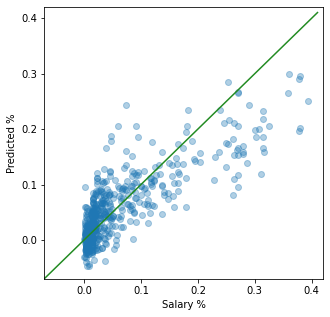

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.scatter(final_df2_diff['Salary %'], final_df2_diff['Pred'], alpha=0.35)
ax.set_xlim([-0.07, 0.42])
ax.set_ylim([-0.07, 0.42])
ax.set_xlabel('Salary %')
ax.set_ylabel('Predicted %')
plt.plot(np.arange(-0.07, 0.42, 0.01), np.arange(-0.07, 0.42, 0.01), 'forestgreen')
# fig.savefig('salary_vs_pred.png')

In [ ]:
final_df2_team = pd.merge(final_df2, joint_df.loc[joint_df['Year'] == 2021][['Player', 'Team']], 
                          how='inner', on=['Player'])
final_df2_team['Diff'] = final_df2_team['Salary %'] - final_df2_team['Pred']


In [359]:
final_df2_team = pd.read_csv('teams.csv')
final_df2_teamp = final_df2_team[['Team', 'Diff']].groupby(['Team']).sum().reset_index().sort_values(by=['Diff'])
final_df2_teamp

,Team,Diff
20,OKC,-0.369048
19,NYK,-0.292568
6,DAL,-0.044977
13,LAL,-0.039270
0,ATL,-0.027094
14,MEM,-0.018122
3,CHI,-0.006152
8,DET,-0.001927
16,MIL,0.008684
10,HOU,0.032556


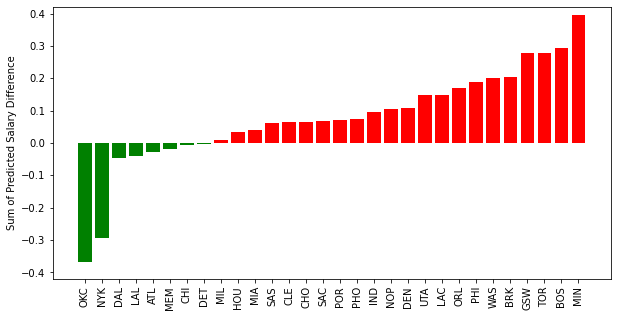

In [370]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
threshold = 0
above_t = np.maximum(final_df2_teamp['Diff'] - threshold, 0)
below_t = np.minimum(final_df2_teamp['Diff'], threshold)
ax.bar(final_df2_teamp['Team'], below_t, color='g')
ax.bar(final_df2_teamp['Team'], above_t, color='r', bottom=below_t)

plt.xticks(rotation = 90)
plt.ylim([-0.42, 0.42])
ax.set_ylabel('Sum of Predicted Salary Difference')

# fig.savefig('sum_diffs.png')

In [374]:
final_df2_diff.sort_values(by=['Pred'], ascending=False).head(n=10)

,Player,Salary %,Pred,Diff
4129,LeBron James,0.359351,0.298623,0.060728
4126,Russell Westbrook,0.378952,0.295067,0.083885
4127,James Harden,0.378000,0.290224,0.087776
4160,Giannis Antetokounmpo,0.252227,0.285585,-0.033358
4147,Nikola Jokic,0.270680,0.266694,0.003986
4149,Joel Embiid,0.270680,0.264796,0.005884
4130,Kevin Durant,0.357879,0.264155,0.093724
4124,Stephen Curry,0.394048,0.250188,0.143859
4263,Luka Doncic,0.073753,0.244216,-0.170463
4141,Damian Lillard,0.289783,0.242503,0.047280


In [378]:
adv_list = list(adv_df.columns)
adv_list

['Player',
 'Year',
 'Salary',
 'Salary %',
 'Position',
 'Age',
 'Team',
 'GP',
 'Minutes',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV',
 'USG%',
 'OWS',
 'DWS',
 'WS',
 'WS/48',
 'OBPM',
 'DBPM',
 'BPM',
 'VORP']